In [2]:
import os

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.functional import accuracy
import torchvision

import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import numpy as np

In [3]:
BATCH_SIZE = 256 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2)

In [4]:
transformation = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

# Download the dataset and create the dataloaders
mnist_data = datasets.MNIST("./", train=True, download=True, transform=transformation)

mnist_train, mnist_val = torch.utils.data.random_split(mnist_data, [55000, 5000])

train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, persistent_workers=True)
val_loader = DataLoader(mnist_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, persistent_workers=True)

mnist_test = datasets.MNIST("./", train=False, download=True, transform=transformation)
test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, persistent_workers=True)

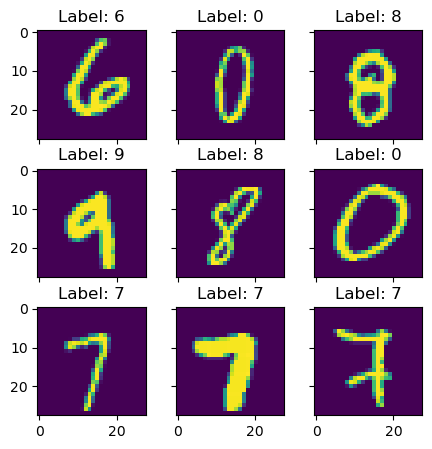

In [5]:
# show the first 9 images of the train loader with their labels
for images,lables in train_loader: 
    images = images[:9]
    fig = plt.figure(1, (5., 5.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                    axes_pad=0.3,  # pad between axes in inch.
                    )

    for i in range(len(images)):
        image = images[i].reshape(28,28)
        grid[i].imshow(image)
        grid[i].set_title('Label: {0}'.format(lables[i]))

    plt.show()
    break

In [5]:
class MnistCNN(nn.Module):
    def __init__(self):
        super(MnistCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 3, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(3, 6, 3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(726, 120),
            nn.ReLU(),
            nn.Linear(120, 10)
        )

    def forward(self, x):
        return self.model(x)

In [6]:
class LightningMNISTClassifier(L.LightningModule):

  def __init__(self, num_classes, lr):
    super(LightningMNISTClassifier, self).__init__()
    
    self.save_hyperparameters(ignore=['model'])
    self.model = MnistCNN()
    self.num_classes = num_classes

  def forward(self, x):
      return self.model(x)

  def training_step(self, batch, batch_idx):
      # training_step defines the train loop.
      images, labels = batch
        
      # Forward pass
      outputs = self.model(images)
      loss = F.cross_entropy(outputs, labels)
        
      # Logging to TensorBoard (if installed) by default
      self.log("train_loss", loss)
        
      return loss
    
  def evaluate(self, batch, stage=None):
      images, labels = batch
        
      # Forward pass
      outputs = self.model(images)
      loss = F.cross_entropy(outputs, labels)
        
      acc = accuracy(outputs, labels, task="multiclass", num_classes=self.num_classes)

      if stage:
          self.log(f"{stage}_loss", loss, prog_bar=True)
          self.log(f"{stage}_acc", acc, prog_bar=True)
    
  def validation_step(self, batch, batch_idx):
      self.evaluate(batch, "val")
    
  def test_step(self, batch, batch_idx):
      self.evaluate(batch, "test")

  def configure_optimizers(self):
      return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [7]:
Train = False
if Train:
    convNet = LightningMNISTClassifier(lr=0.001, num_classes=10)
    #logger = CSVLogger("logs", name="my_logs")
    logger = TensorBoardLogger("tb_logs", name="mnist_model")
    trainer = L.Trainer(max_epochs=20, 
                        callbacks=[EarlyStopping(monitor="val_loss", mode="min")],
                        accelerator="auto",
                        #devices=1 if torch.cuda.is_available() else None,
                        logger=logger,
                        fast_dev_run=False)

    # train the model
    trainer.fit(convNet, train_dataloaders=train_loader, val_dataloaders=val_loader)

    # test the model
    trainer.test(convNet, dataloaders=test_loader)
    
    trainer.save_checkpoint("best_mnist_cnn_model.ckpt")

In [25]:
# method from tutorial converted to pytorch
def plot_predictions(model, image_list, output_probs=False, adversarial=False):
    '''
    Evaluate images against trained model and plot images.
    If adversarial == True, replace middle image title appropriately
    Return probability list if output_probs == True
    '''
    #prob = y.eval(feed_dict={x: image_list, keep_prob: 1.0})
    prob = model(image_list)
    probabilities = torch.nn.functional.softmax(prob, dim=1)
    
    pred_list = np.zeros(len(image_list)).astype(int)
    pct_list = np.zeros(len(image_list)).astype(int)
    
    # Setup image grid
    import math
    cols = 3
    rows = math.ceil(image_list.shape[0]/cols)
    fig = plt.figure(1, (12., 12.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  # creates grid of axes
                     axes_pad=0.5,  # pad between axes in inch.
                     )
    
    # Get probs, images and populate grid
    for i in range(len(prob)):
        pred_list[i] = np.argmax(probabilities[i].detach().numpy()) # for mnist index == classification
        
        #pct_list[i] = probabilities[i][pred_list[i]] * 100 # try round 
        pct_list[i] = round(probabilities[i][pred_list[i]].item(),3) * 100

        image = image_list[i].reshape(28,28)
        grid[i].imshow(image.detach().numpy())
        
        grid[i].set_title('Label: {0} \nCertainty: {1}%' \
                          .format(pred_list[i], 
                                  pct_list[i]))
        
        # Only use when plotting original, partial deriv and adversarial images
        if (adversarial) & (i % 3 == 1): 
            grid[i].set_title("Adversarial \nPartial Derivatives")
        
    plt.show()
    
    return prob if output_probs else None

In [26]:
# get 10 images with label 2
indices = mnist_test.targets == 2 # if you want to keep images with the label 2
images= mnist_test.data[indices].type(torch.float32)
images = images[:10]
images = images.unsqueeze(1)

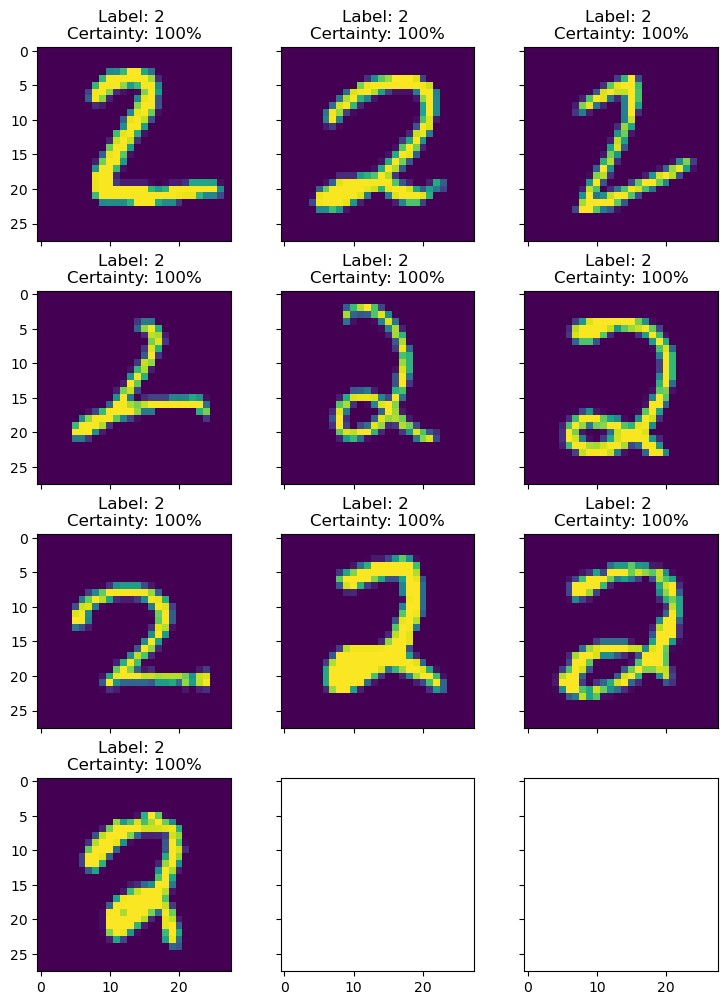

In [27]:
# load model
cnn_mnist = LightningMNISTClassifier.load_from_checkpoint("best_mnist_cnn_model.ckpt")

# disable randomness, dropout, etc...
cnn_mnist.eval()
    
with torch.no_grad():
    # predict the label for all the selected 2s
    plot_predictions(cnn_mnist, images)

In [11]:
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA Available:  False


In [19]:
# method from tutorial to create adversarial images
def create_plot_adversarial_images(model, x_image, y_label, lr=0.1, n_steps=1, output_probs=False):
    original_image = x_image.clone().detach()
    probs_per_step = []

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD([x_image.requires_grad_()], lr=lr)

    for _ in range(n_steps):
        optimizer.zero_grad()
        output = model(x_image)
        loss = criterion(output, y_label)
        loss.backward()
        gradient = x_image.grad
        x_adv = x_image - lr * gradient.sign() /n_steps
        x_adv = torch.clamp(x_adv, 0, 1)  # clip to [0, 1] range
        x_image = x_adv.detach().requires_grad_(True)  # detach to prevent further gradient calculation

        # Create array of 3 images - orig, noise/delta, adversarial
        img_adv_list = torch.cat((original_image,gradient, x_image), dim=0)

        # Print/plot images and return probabilities
        probs = plot_predictions(model, img_adv_list, output_probs=output_probs, adversarial=True)
        probs_per_step.append(probs) if output_probs else None

    return probs_per_step

In [20]:
# get images with label 4 and try to trick the network to predict 9s
index_of_2s = mnist_test.targets == 4
rand_index = np.random.randint(0, index_of_2s.sum())
image_norm = mnist_test.data[index_of_2s][rand_index].type(torch.float32).unsqueeze(0).unsqueeze(1)
print(image_norm.dtype)
image_norm.requires_grad = True
label_adv = torch.tensor([9], dtype=torch.long)

torch.float32


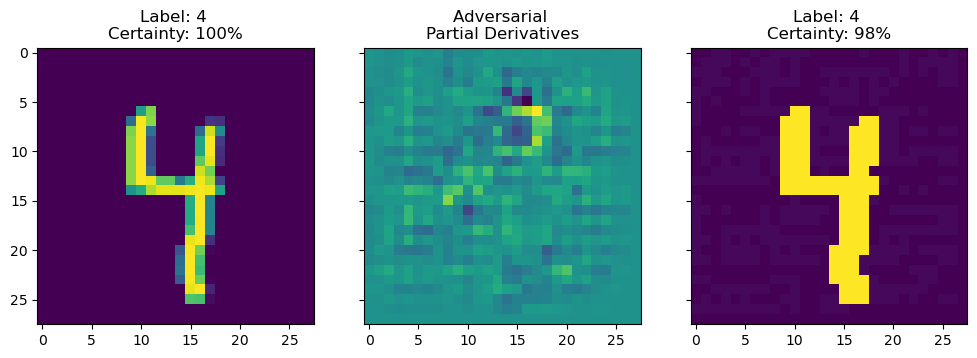

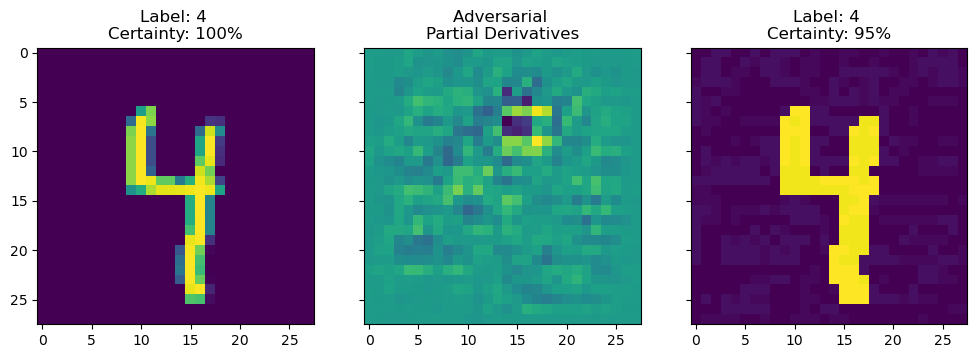

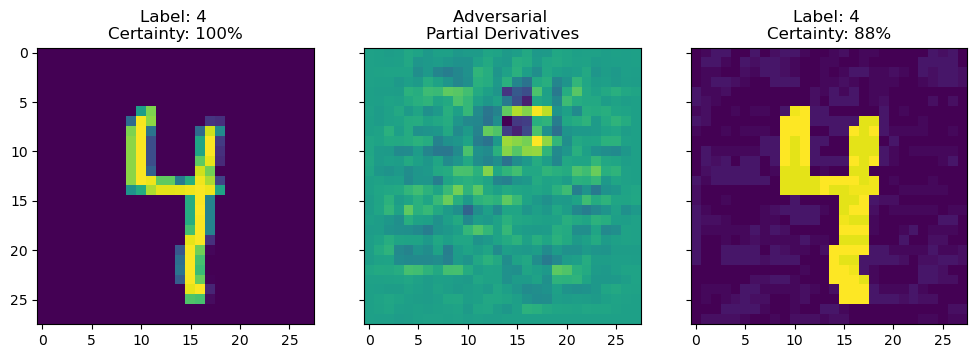

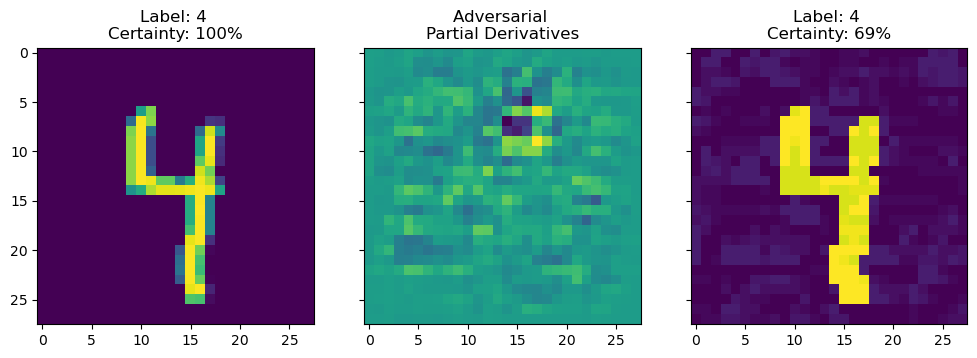

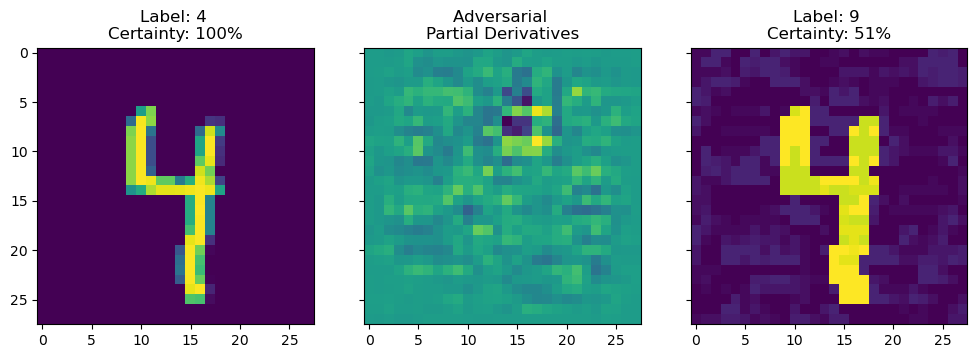

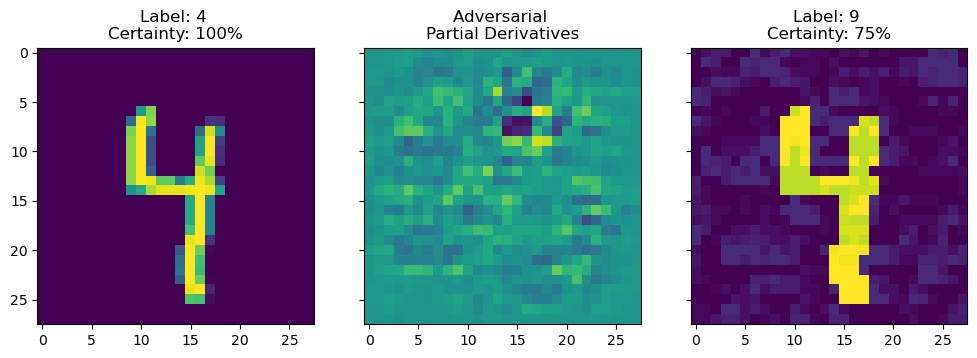

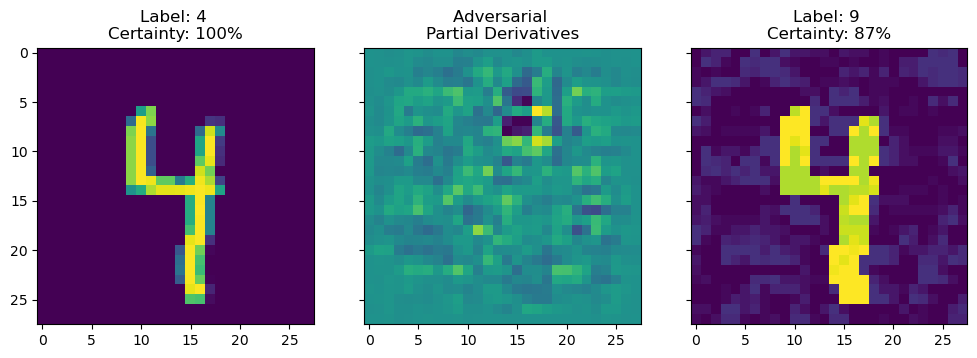

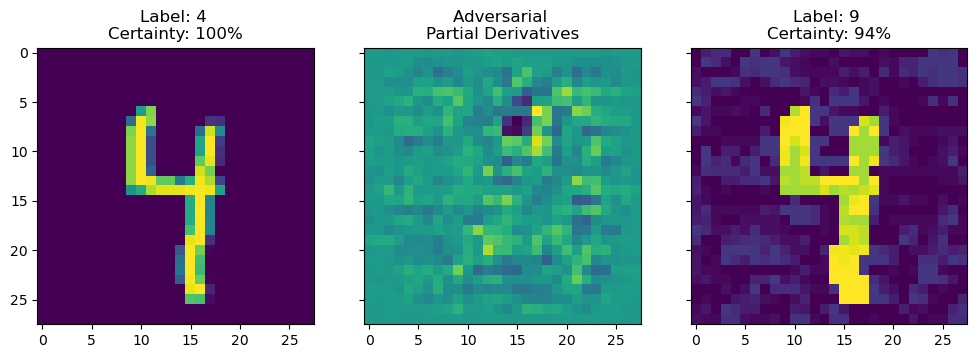

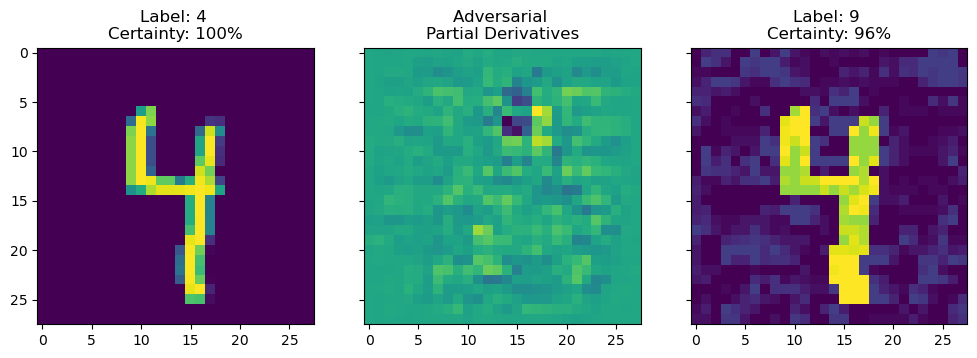

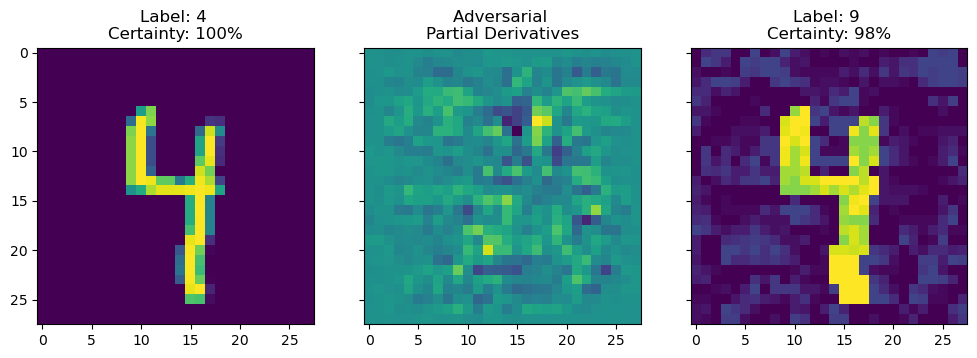

[]

In [28]:
# Plot adversarial images
# Over each step, model certainty changes from 2 to 6
create_plot_adversarial_images(cnn_mnist, image_norm, label_adv, lr=0.2, n_steps=10)